# Kaggle WM-811K dataset으로 wafer의 defect 불량을 CNN으로 검출해보기

In [27]:
import os
from os.path import join

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import cross_val_score, train_test_split, KFold

import matplotlib.pyplot as plt
import cv2
import random

import warnings
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Lambda

## sklearn kfold cross validation 이용해서 검증할 모델 생성.

In [28]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
        return tf.math.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

    return contrastive_loss


def create_resnet():
    conv_base = tf.keras.applications.ResNet50(weights="imagenet",
                                            include_top=False,
                                            pooling = 'max',
                                            input_shape=(60,60,3))
    
    for layer in [l for l in conv_base.layers if 'conv5' not in l.name]:
        layer.trainable = False
    for layer in [l for l in conv_base.layers if 'conv5' in l.name or l.name == 'probs']:
        layer.trainable = True
        
    #conv_base.trainable = False
    
    model = tf.keras.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.2)))  
    
    return model

def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, 1e-7))    

checkpoint_path = "C:/Users/user/Desktop/sh/siamese/새 폴더/weight_wafer/cp-{epoch:02d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True, save_freq='epoch',  monitor='val_loss', verbose=1, mode="min")

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                              patience=4)

In [29]:
base_model = create_resnet()
input_a = Input(shape=(60,60,3), name='left_input')
vector_output_a = base_model(input_a)
input_b = Input(shape=(60,60,3), name='right_input')
vector_output_b = base_model(input_b)
output = Lambda(euclidean_distance, name='output_layer')([vector_output_a, vector_output_b])

In [30]:
max_point2 = 10

In [31]:
model_trained = Model([input_a, input_b], output)
model_trained.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=Adam())

if max_point2 > 8:
    model_trained.load_weights(
        "C:/Users/user/Desktop/sh/siamese/새 폴더/weight/cp-" + str(max_point2+1) + ".ckpt"
    )
else:
    model_trained.load_weights(
        "C:/Users/user/Desktop/sh/siamese/새 폴더/weight/cp-0" + str(max_point2+1) + ".ckpt"
    )

In [32]:
path = 'C:/Users/user/Desktop/kamp/MetaLearning-pytorch/siamese/wafer/1per/train' # 폴더 경로
os.chdir(path) # 해당 폴더로 이동
error_list = os.listdir(path) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음

Center_list = []
Donut_list = []
Edge_Loc_list = []
Edge_Ring_list = []
Loc_list = []
Near_full_list = []
none_list = []
Random_list = []
Scratch_list = []

for error in error_list:
    path = 'C:/Users/user/Desktop/kamp/MetaLearning-pytorch/siamese/wafer/1per/train/' + error # 폴더 경로
    os.chdir(path) # 해당 폴더로 이동
    file_list = os.listdir(path) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음
    
    for file in file_list:
        f = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        f = f / 2
        image = cv2.resize(f, (60, 60))
        image = image[:,:, np.newaxis]
        image2 = np.repeat(image, 3, axis=2)
        
        if error == 'Center':
            Center_list.append(image2)
        elif error == 'Donut':
            Donut_list.append(image2)
        elif error == 'Edge-Loc':
            Edge_Loc_list.append(image2)
        elif error == 'Edge-Ring':
            Edge_Ring_list.append(image2)
        elif error == 'Loc':
            Loc_list.append(image2)
        elif error == 'Near-full':
            Near_full_list.append(image2)
        elif error == 'none':
            none_list.append(image2)
        elif error == 'Random':
            Random_list.append(image2)
        elif error == 'Scratch':
            Scratch_list.append(image2)                                                                               

In [33]:
#0은 okay / 1은 error
import random

image_list = [Center_list, Donut_list, Edge_Loc_list, Edge_Ring_list, Loc_list, Near_full_list, none_list, Random_list, Scratch_list]

def create_pairs(image_list, dataset_size):
    pairs = []
    answer = []
    
    for i in range(dataset_size):
        prob = np.random.rand()
        
        first_class = np.random.randint(9)
        second_class = np.random.randint(9)
        
        while (first_class == second_class):
            second_class = np.random.randint(9)
                                                            
        if prob > 0.5:
            answer.append(1)
            pairs.append(random.sample(image_list[first_class],2))
        
        else:
            answer.append(0)
            pairs.append([random.sample(image_list[first_class],1)[0] ,  random.sample(image_list[second_class],1)[0]])
        
        
    return np.array(pairs), answer

train_X_pair, train_y_pair = create_pairs(image_list, 2000)

In [34]:
train_X_pair.shape

(2000, 2, 60, 60, 3)

In [35]:
path = 'C:/Users/user/Desktop/kamp/MetaLearning-pytorch/siamese/wafer/1per/val' # 폴더 경로
os.chdir(path) # 해당 폴더로 이동
error_list = os.listdir(path) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음

Center_list = []
Donut_list = []
Edge_Loc_list = []
Edge_Ring_list = []
Loc_list = []
Near_full_list = []
none_list = []
Random_list = []
Scratch_list = []

for error in error_list:
    path = 'C:/Users/user/Desktop/kamp/MetaLearning-pytorch/siamese/wafer/1per/val/' + error # 폴더 경로
    os.chdir(path) # 해당 폴더로 이동
    file_list = os.listdir(path) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음
    
    for file in file_list:
        f = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        f = f / 2
        image = cv2.resize(f, (60, 60))
        image = image[:,:, np.newaxis]
        image2 = np.repeat(image, 3, axis=2)
        
        if error == 'Center':
            Center_list.append(image2)
        elif error == 'Donut':
            Donut_list.append(image2)
        elif error == 'Edge-Loc':
            Edge_Loc_list.append(image2)
        elif error == 'Edge-Ring':
            Edge_Ring_list.append(image2)
        elif error == 'Loc':
            Loc_list.append(image2)
        elif error == 'Near-full':
            Near_full_list.append(image2)
        elif error == 'none':
            none_list.append(image2)
        elif error == 'Random':
            Random_list.append(image2)
        elif error == 'Scratch':
            Scratch_list.append(image2)                                                                               

In [36]:
image_list = [Center_list, Donut_list, Edge_Loc_list, Edge_Ring_list, Loc_list, Near_full_list, none_list, Random_list, Scratch_list]

val_X_pair, val_y_pair = create_pairs(image_list, 2000)

In [37]:
model_trained.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=Adam())
              
history = model_trained.fit([train_X_pair[:, 0, :,:,:] ,train_X_pair[:, 1, :,:,:]] , np.array(train_y_pair,dtype=np.float64),
                    epochs=30, batch_size = 32, callbacks= [earlystopping, cp_callback],
                    validation_data=([val_X_pair[:,0,:,:,:] , val_X_pair[:, 1, :,:,:]] , np.array(train_y_pair,dtype=np.float64) ) )    
                               

Epoch 1/30
63/63 [==============================] - 15s 166ms/step - loss: 0.2458 - val_loss: 0.3574

Epoch 00001: saving model to C:/Users/user/Desktop/sh/siamese/새 폴더/weight_wafer\cp-01.ckpt
Epoch 2/30
63/63 [==============================] - 9s 143ms/step - loss: 0.1437 - val_loss: 0.3488

Epoch 00002: saving model to C:/Users/user/Desktop/sh/siamese/새 폴더/weight_wafer\cp-02.ckpt
Epoch 3/30
63/63 [==============================] - 9s 138ms/step - loss: 0.1245 - val_loss: 0.3911

Epoch 00003: saving model to C:/Users/user/Desktop/sh/siamese/새 폴더/weight_wafer\cp-03.ckpt
Epoch 4/30
63/63 [==============================] - 9s 136ms/step - loss: 0.1081 - val_loss: 0.3569

Epoch 00004: saving model to C:/Users/user/Desktop/sh/siamese/새 폴더/weight_wafer\cp-04.ckpt
Epoch 5/30
63/63 [==============================] - 8s 135ms/step - loss: 0.1037 - val_loss: 0.3566

Epoch 00005: saving model to C:/Users/user/Desktop/sh/siamese/새 폴더/weight_wafer\cp-05.ckpt
Epoch 6/30
63/63 [=====================

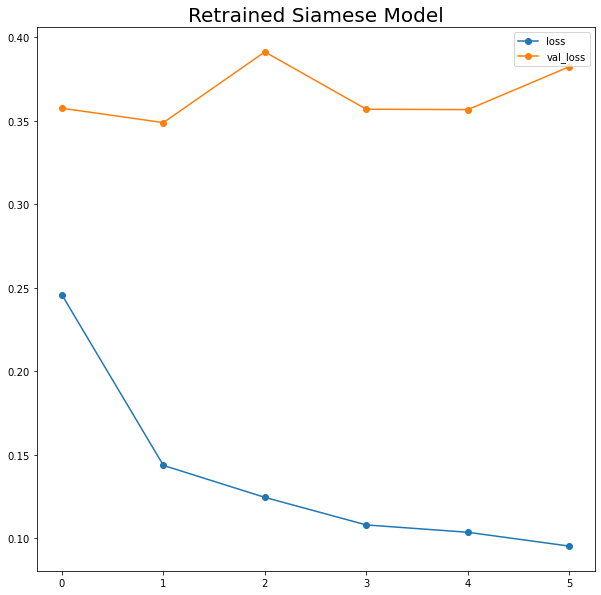

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

hist = history
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
ax = fig.add_subplot()

ax.plot(hist.history["loss"], label = 'loss', marker='o')
ax.plot(hist.history["val_loss"], label = 'val_loss', marker='o')
ax.legend()

plt.title('Retrained Siamese Model', fontsize=20)
plt.show()

In [39]:
val_loss_history = hist.history["val_loss"]
max_point = val_loss_history.index(min(val_loss_history))

In [40]:
max_point

1